In [3]:
from torchvision import *
import torchvision as vision
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = models.vit_b_16(weights='IMAGENET1K_V1')
# model = torch.nn.Sequential(*(list(model.children())[:-1]))
df = pd.read_csv('../datasets/processed/pokemon.csv')
# chosen = [20, 100]
# df = df.query('dex  in @chosen')

df = df[df['dex'] <= 151]
df

,name,image,type1,type2,dex
0,bulbasaur,../datasets/raw/renders_2d/images/1.png,grass,poison,1
1,ivysaur,../datasets/raw/renders_2d/images/2.png,grass,poison,2
2,venusaur,../datasets/raw/renders_2d/images/3.png,grass,poison,3
3,charmander,../datasets/raw/renders_2d/images/4.png,fire,NaN,4
4,charmeleon,../datasets/raw/renders_2d/images/5.png,fire,NaN,5
...,...,...,...,...,...
146,dratini,../datasets/raw/renders_2d/images/147.png,dragon,NaN,147
147,dragonair,../datasets/raw/renders_2d/images/148.png,dragon,NaN,148
148,dragonite,../datasets/raw/renders_2d/images/149.png,dragon,flying,149
149,mewtwo,../datasets/raw/renders_2d/images/150.png,psychic,NaN,150


In [13]:

# add layers to model, to complete decoder part of autoencoder
model = torch.nn.Sequential(model, torch.nn.Linear(1000, 64))
model = torch.nn.Sequential(model, torch.nn.ReLU())
model = torch.nn.Sequential(model, torch.nn.Linear(64, 128))
model = torch.nn.Sequential(model, torch.nn.ReLU())
model = torch.nn.Sequential(model, torch.nn.Linear(128, 128))
model = torch.nn.Sequential(model, torch.nn.ReLU())
model = torch.nn.Sequential(model, torch.nn.Linear(128, 128))
model = torch.nn.Sequential(model, torch.nn.ReLU())
model = torch.nn.Sequential(model, torch.nn.Linear(128, 150528))
model = torch.nn.Sequential(model, torch.nn.Sigmoid())

# use convolutional layers to complete decoder part of autoencoder
# model = torch.nn.Sequential(model, torch.nn.Conv2d(1, 64, 3, padding=1))
# model = torch.nn.Sequential(model, torch.nn.ReLU())
# model = torch.nn.Sequential(model, torch.nn.Conv2d(64, 128, 3, padding=1))
# model = torch.nn.Sequential(model, torch.nn.ReLU())
# model = torch.nn.Sequential(model, torch.nn.Conv2d(128, 256, 3, padding=1))
# model = torch.nn.Sequential(model, torch.nn.ReLU())
# model = torch.nn.Sequential(model, torch.nn.Conv2d(256, 150528, 3, padding=1))
# model = torch.nn.Sequential(model, torch.nn.Sigmoid())

In [21]:
# try:
#     checkpoint = torch.load('../model_checkpoints/pokemon_autoencoder.pt')
# except:
#     checkpoint = None
    

SyntaxError: expected 'except' or 'finally' block (3085369885.py, line 3)

In [22]:
# finetune model on pokemon dataset
model.to(device)
epochs = 500
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

if checkpoint:
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    current_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
else:
    current_epoch = 0
    loss = 0

In [ ]:
for epoch in range(current_epoch, epochs):
    for i in df.index:
        img = Image.open(df['image'][i])
        img = img.convert('RGB')
        img = vision.transforms.Resize((224, 224))(img)
        img = vision.transforms.ToTensor()(img)
        img = img.unsqueeze(0)
        img = img.flatten().to(device)
        image = Image.open(df['image'][i])
        image = image.convert('RGB')
        image = vision.transforms.Resize((224, 224))(image)
        image = vision.transforms.ToTensor()(image)
        image = image.unsqueeze(0).to(device)
        output = model(image).to(device)
        loss = criterion(input= output, target= img)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'Epoch: {epoch}, Loss: {loss}')

# save model
torch.save(model, 'pokemon_autoencoder.pth')

In [24]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, '../model_checkpoints/pokemon_autoencoder.pt')

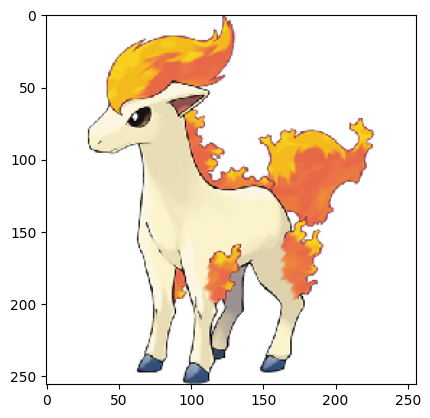

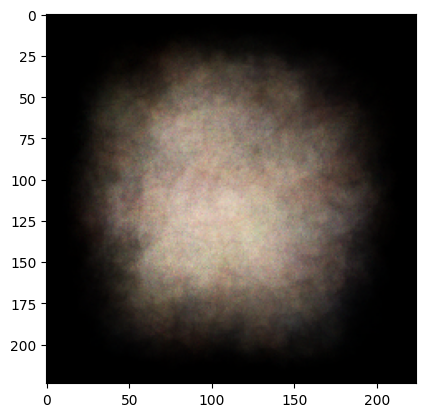

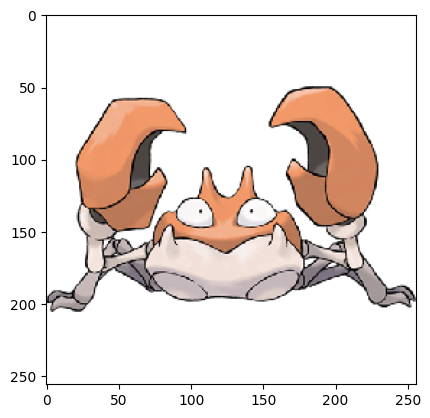

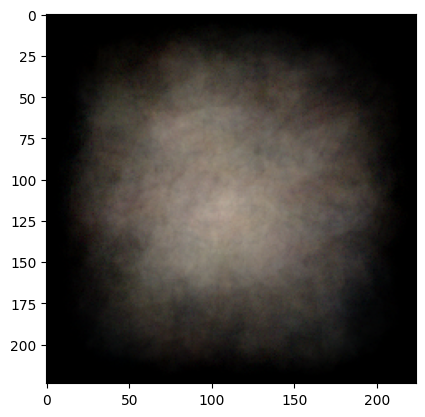

In [16]:
# df = pd.read_csv('../datasets/processed/pokemon.csv')
outputs = []

df_example = df.sample(2)
# show 5 reconstructed images
for i in df_example.index:
    img = Image.open(df_example['image'][i])
    image = Image.open(df_example['image'][i])
    image = image.convert('RGB')
    image = vision.transforms.Resize((224, 224))(image)
    image = vision.transforms.ToTensor()(image)
    image = image.unsqueeze(0).to(device)
    output = model(image)
    output = output.view(3, 224, 224)
    output = vision.transforms.ToPILImage()(output)
    outputs.append(output)
    plt.figure(i+10)
    plt.imshow(img)
    plt.show()
    plt.figure(i+20)
    plt.imshow(output)
    plt.show()

In [17]:
model.state_dict

<bound method Module.state_dict of Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Sequential(
          (0): Sequential(
            (0): Sequential(
              (0): Sequential(
                (0): Sequential(
                  (0): Sequential(
                    (0): VisionTransformer(
                      (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
                      (encoder): Encoder(
                        (dropout): Dropout(p=0.0, inplace=False)
                        (layers): Sequential(
                          (encoder_layer_0): EncoderBlock(
                            (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
                            (self_attention): MultiheadAttention(
                              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
                            )
                            (dropout): Dropout(p=0.0, inpla